# 패키지 다운로드

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt

import warnings

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

warnings.filterwarnings("ignore")

# 데이터 셋 확인

In [64]:
rawdata = pd.read_csv("./구리 수요/수요 변수_최종.csv")
display(rawdata)

# 날짜 데이터를 제외한 나머지값만 data 변수로 저장
data_no_date = rawdata.drop("Date", axis = 1)

,Date,HSI_value,CCI_value,IPI_value,GDPC_value,Copper price,PX_LAST
0,1995-01-31,1407,100.83360,71.2762,10550.251,1.380976,969917.000
1,1995-02-28,1316,100.94720,71.1904,10550.251,1.322179,960039.000
2,1995-03-31,1249,101.02100,71.2891,10550.251,1.351283,1043928.000
3,1995-04-30,1267,100.98750,71.1623,10581.723,1.328911,1022904.000
4,1995-05-31,1314,100.98590,71.5044,10581.723,1.260091,979813.000
...,...,...,...,...,...,...,...
334,2022-11-30,1427,96.77289,103.0707,20182.491,3.656582,2237807.240
335,2022-12-31,1357,97.26849,101.4848,20182.491,3.817891,2148356.118
336,2023-01-31,1340,97.72659,102.5080,20246.439,4.118691,2121282.622
337,2023-02-28,1436,98.16353,102.5023,20246.439,4.082400,1975076.391


# 데이터 표준화

In [31]:
# 원본데이터의 값만 numpy 2차원 배열로 전환
dataset = data_no_date.values

# 행 기준으로 평균, 표준편차를 구해 표준화 진행
data_mean = dataset.mean(axis=0)
data_std = dataset.std(axis=0)
dataset = (dataset-data_mean)/data_std

print(dataset.shape)

(339, 6)


# 타임 스텝 별 데이터 분리 함수

In [21]:
# dataset: 데이터셋
# target: 종속변수
# start_index: 시작 행 번호
# end_index: 끝 행 번호
# history_size: 학습시킬 데이터의 양
# target_size: 미래 예측할 기간
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size):
    
    data = []
    labels = []
    
    # 데이터 분리를 반복해서 진행할 시작값 설정
    start_index = start_index + history_size
    
    # 데이터 분리를 반복해서 진행할 끝값 설정
    if end_index is None:
        end_index = len(dataset) - target_size

    # 시작값부터 끝값까지 데이터 분리를 반복하는 반복분 설정
    for i in range(start_index, end_index):
        
        # 데이터 분리할 범위 설정
        indices = range(i - history_size, i)
        
        # numpy 2차원 배열에서 데이터 범위만큼 학습 데이터 분리
        data.append(dataset[indices])

        # 종속변수의 미래예측 범위만큼 데이터 분리
        labels.append(target[i:i + target_size])
            
    # 실행 결과값을 numnpy 2차원 배열로 학습데이터와 평가데이터 return
    return np.array(data), np.array(labels)

# 모델 학습 및 검증 손실 변화 시각화 함수

In [7]:
# histroy: 모델 학습 과정 중 epoch마다의 손실율을 저장한 DataFrame
# title: 시각화한 그래프의 제목
def plot_train_history(history, title):
    
    # 모델 학습 시의 손실율 저장
    loss = history.history['loss']
    
    # 모델 평가 시의 손실율 저장
    val_loss = history.history['val_loss']

    # 전체 epochs의 길이 변수로 저장
    epochs = range(len(loss))

    # 손실율 함수 그래프 그리기
    plt.figure()

    ## 학습 손실율
    plt.plot(epochss, loss, 'b', label='Training loss')
    
    ## 평가 손실율
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    
    ## 그래프 제목
    plt.title(title)
    
    ## 그래프 범례
    plt.legend()

    plt.show()

# 하이퍼 파라매터 설정

In [23]:
# 학습 데이터의 수 지정
TRAIN_SPLIT = 300

# 모델 학습 시 사용할 데이터의 크기
BATCH_SIZE = 32

# 한 번의 학습에 사용할 배치의 크기
EVALUATION_INTERVAL = 16

# 전체 학습 데이터를 학습 반복 단위
EPOCHS = 50

# 학습할 데이터의 개월 수 지정
past_history = 12

# 예측할 미래의 개월 수 지정
future_target = 6

# 랜덤 시드 고정
tf.random.set_seed(13)

# 타임 스텝별 독립변수와 종속변수 추출

In [26]:
# 학습데이터 분리
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, -1], 0, TRAIN_SPLIT, past_history, future_target)

# 평가데이터 분리
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, -1], TRAIN_SPLIT, None, past_history, future_target)

# 분리된 데이터의 차원 확인
print("--- 학습데이터 확인 ---")
print(x_train_multi.shape)
print(y_train_multi.shape)

print("--- 평가데이터 확인 ---")
print(x_val_multi.shape)
print(y_val_multi.shape)

print("--- 데이터 분리 확인 ---")
print('학습할 과거의 차원 확인 : {}'.format(x_train_multi[0].shape))
print('예측할 미래의 개월 수 확인 : {}'.format(y_train_multi[0].shape))

--- 학습데이터 확인 ---
(288, 12, 6)
(288, 6)
--- 평가데이터 확인 ---
(21, 12, 6)
(21, 6)
--- 데이터 분리 확인 ---
학습할 과거의 차원 확인 : (12, 6)
예측할 미래의 개월 수 확인 : (6,)


# 학습 및 평가 데이터 추출

In [244]:
# 데이터 shuffle할 때 할당할 버퍼의 크기(크기가 클수록 한번에 많은 데이터를 shuffle하지만 메모리를 많이 잡아먹음)
BUFFER_SIZE = 10000

# 학습데이터를 tensorflow의 데이터셋으로 변환
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))

# 모델 학습 성능향상을 위해 학습데이터를 캐싱
# BUFFER_SIZE만큼 데이터를 shuffle
# BATCH_SIZE만큼 데이터를 하나로 묶음
# repeat()를 통해 학습할 데이터의 양을 늘림
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

# 평가데이터를 tensorflow의 데이터셋으로 변환
val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))

# BATCH_SIZE만큼 데이터를 하나로 묶음
# repeat()를 통해 학습할 데이터의 양을 늘림
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

# LSTM 모델 구축 및 학습

Epoch 1/50
16/16 [==============================] - 5s 53ms/step - loss: 0.6076 - val_loss: 0.6343
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 0.3656 - val_loss: 0.3778
Epoch 3/50
16/16 [==============================] - 0s 10ms/step - loss: 0.2065 - val_loss: 0.3260
Epoch 4/50
16/16 [==============================] - 0s 10ms/step - loss: 0.1814 - val_loss: 0.3541
Epoch 5/50
16/16 [==============================] - 0s 10ms/step - loss: 0.1739 - val_loss: 0.3677
Epoch 6/50
16/16 [==============================] - 0s 10ms/step - loss: 0.1703 - val_loss: 0.2651
Epoch 7/50
16/16 [==============================] - 0s 9ms/step - loss: 0.1686 - val_loss: 0.2651
Epoch 8/50
16/16 [==============================] - 0s 10ms/step - loss: 0.1669 - val_loss: 0.2730
Epoch 9/50
16/16 [==============================] - 0s 11ms/step - loss: 0.1668 - val_loss: 0.2359
Epoch 10/50
16/16 [==============================] - 0s 13ms/step - loss: 0.1670 - val_loss: 0.1818
Epoch 11/5

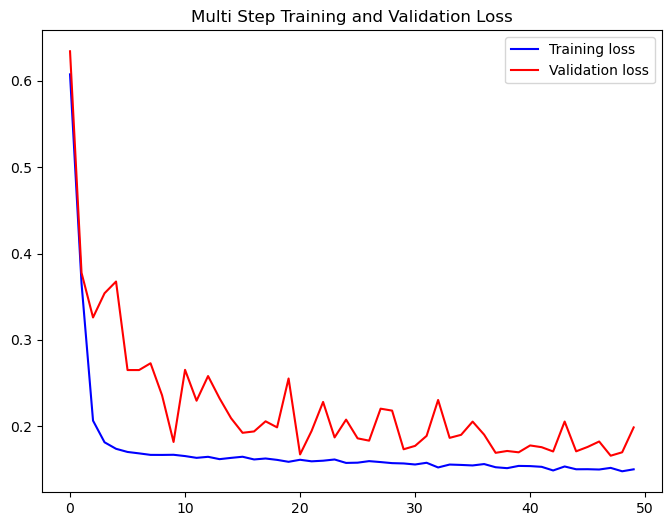

In [245]:
# 모델 정의
multi_step_model = tf.keras.models.Sequential()

# LSTM 레이어 추가
## BATCH_SIZE와 입력값을 동일하게 설정
## 레이어 추가를 위해 출력 시퀀스를 반환하도록 설정
## 입력값을 학습데이터의 차원(2차원, 12행 6열)으로 설정
multi_step_model.add(tf.keras.layers.LSTM(32, return_sequences=True, input_shape=x_train_multi.shape[-2:]))

# LSTM 레이어 추가
## 활성화함수 ReLU 사용: 모델에 비선형성을 추가하여 복잡한 패턴 학습 가능
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))

# 출력 레이어 추가
## 예측할 개월 수만큼 뉴런의 개수 설정
multi_step_model.add(tf.keras.layers.Dense(6)) 

# 모델의 학습방법 설정
## optimizer: RMSprop(경사하강법)
## clipvalue를 1로 설정하여 그라디언트값의 발산범위를 제한하여 학습성능을 높임
## 손실함수: MAE(평균절대오차)
multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

# 모델 학습
## train_data_multi: tensorflow 데이터셋으로 된 학습데이터
## epochs: 모델 학습을 50회 반복해서 진행
## steps_per_epoch: 한 에폭당 16개의 배치를 사용
## validation_data: 평가데이터
## validation_steps: 1번의 에폭 진행 후 평가 진행
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_data_multi, validation_steps=1)

# 손실함수 그래프 그리기
plot_train_history(multi_step_history, 'Multi Step Training and Validation Loss')

# 예측 결과 시각화

In [32]:
# 원본데이터 불러오기
temp_df = rawdata

# 종속변수 표준화
MOVING_MEAN = temp_df["PX_LAST"].mean(axis=0)
MOVING_STD = temp_df["PX_LAST"].std(axis=0)
temp_df["PX_LAST_STD"] = (temp_df["PX_LAST"] - MOVING_MEAN) / MOVING_STD

# 표준화된 종속변수 9개월치 지수이동평균선 그리기
temp_df["PX_LAST_STD_EWM"] = temp_df["PX_LAST_STD"].ewm(span=9, adjust=False).mean()

# 날짜데이터 index로 설정
temp_df.index = temp_df["Date"]
temp_df = temp_df.drop("Date", axis = 1)

temp_df

,HSI_value,CCI_value,IPI_value,GDPC_value,Copper price,PX_LAST,PX_LAST_STD,PX_LAST_STD_EWM
Date,,,,,,,,
1995-01-31,1407,100.83360,71.2762,10550.251,1.380976,969917.000,-1.616937,-1.616937
1995-02-28,1316,100.94720,71.1904,10550.251,1.322179,960039.000,-1.643726,-1.622295
1995-03-31,1249,101.02100,71.2891,10550.251,1.351283,1043928.000,-1.416220,-1.581080
1995-04-30,1267,100.98750,71.1623,10581.723,1.328911,1022904.000,-1.473237,-1.559512
1995-05-31,1314,100.98590,71.5044,10581.723,1.260091,979813.000,-1.590100,-1.565629
...,...,...,...,...,...,...,...,...
2022-11-30,1427,96.77289,103.0707,20182.491,3.656582,2237807.240,1.821568,1.542308
2022-12-31,1357,97.26849,101.4848,20182.491,3.817891,2148356.118,1.578978,1.549642
2023-01-31,1340,97.72659,102.5080,20246.439,4.118691,2121282.622,1.505555,1.540824


In [63]:
# 전 기간 데이터 학습데이터로 분리하기
x_full_multi, y_full_multi = multivariate_data(dataset, dataset[:, -1], 0, None, past_history, future_target)

# (1995.01 - 1995.12) ~ (2021.6 - 2022.5)
print(x_full_multi.shape)

temp_list = []

temp_list.append(dataset[321:333])
temp_list.append(dataset[322:334])
temp_list.append(dataset[323:335])
temp_list.append(dataset[324:336])
temp_list.append(dataset[325:337])
temp_list.append(dataset[326:338])
temp_list.append(dataset[327:339])

temp_array = np.array(temp_list)
print("---------------")
print(temp_array.shape)

x_full_multi = np.append(x_full_multi, temp_array, axis = 0)
print("---------------")
print(x_full_multi.shape)

(321, 12, 6)
---------------
(7, 12, 6)
---------------
(328, 12, 6)


In [16]:
# 전체 기간 데이터를 tensorflow 데이터셋으로 전환
full_data_multi = tf.data.Dataset.from_tensor_slicesces(x_full_multi)

# BATCH_SIZE를 지정하고 이를 한번만 반복되게 설정
full_data_multi = full_data_multi.batch(BATCH_SIZE).repeat(1)

# 학습한 모델을 통해 미래 데이터를 예측
predict = multi_step_model.predict(full_data_multi)

11/11 [==============================] - 1s 4ms/step


In [17]:
# 예측한 6개월치의 데이터 중 첫 번째 값만 가져오고, 마지막값은 6개월치를 다 가져옴
predict_list = []

for i in range(len(predict)):
    predict_list.append(predict[i][0])
    
    if i == (len(predict) - 1):
        for j in predict[i][1:]:
            predict_list.append(j)
            
len(predict_list)

333

In [18]:
# 1995년 1월부터 2023년 3월까지의 데이터를 학습하여
# 1996년 1월부터 2023년 9월까지의 데이터를 예측

# index에 활용할 월별 datetime값 설정
predict_index = pd.date_range(start='1996-01-01', end='2023-10-01', freq='M')

# 예측값을 DataFrame으로 생성
df_pre = pd.DataFrame(predict_list, index=predict_index, columns=["Predict"])

# 예측값의 9개월치 지수이동평균값 계산
df_pre["Predict_EWM"] = df_pre["Predict"].ewm(span=9, adjust=False).mean()

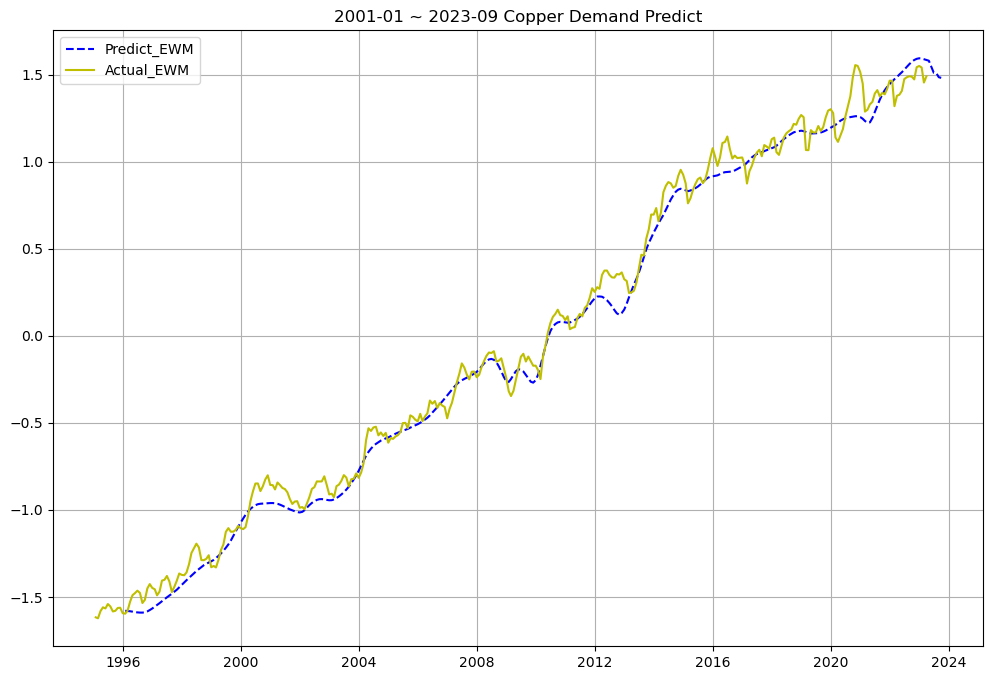

In [19]:
# 그래프 크기
plt.figure(figsize=(12,8))

# 예측값
plt.plot(df_pre["Predict_EWM"], 'b--')

# 실제값
plt.plot(temp_df["PX_LAST_STD_EWM"],'y')

# 그래프 제목
plt.title("2001-01 ~ 2023-09 Copper Demand Predict")

# 그래프 범례
plt.legend(["Predict_EWM", "Actual_EWM"])

# 그래프 격자
plt.grid()

plt.show()

In [25]:
final = pd.concat([df_pre["Predict_EWM"], temp_df["PX_LAST_STD_EWM"]], axis = 1)

final.to_csv("./구리 수요/2차 모델 데이터_수요.csv")

# 공급그래프와 합치기

In [13]:
# 데이터의 기간 조정(2000년 1월 ~ 2023년 3월)
temp_df = rawdata[60:].reset_index(drop=True)

# 종속변수 표준화
MOVING_MEAN = temp_df["PX_LAST"].mean(axis=0)
MOVING_STD = temp_df["PX_LAST"].std(axis=0)
temp_df["PX_LAST_STD"] = (temp_df["PX_LAST"] - MOVING_MEAN) / MOVING_STD

# 종속변수의 9개월치 지수이동평균값 계산
temp_df["PX_LAST_STD_EWM"] = temp_df["PX_LAST_STD"].ewm(span=9, adjust=False).mean()

# DataFrame index를 시간데이터로 설정
temp_df.index = temp_df["Date"]
temp_df = temp_df.drop("Date", axis = 1)

temp_df

,HSI_value,CCI_value,IPI_value,GDPC_value,Copper price,PX_LAST,PX_LAST_STD,PX_LAST_STD_EWM
Date,,,,,,,,
2000-01-31,1636,102.27090,91.4251,12935.252,0.855289,1149296.000,-1.673613,-1.673613
2000-02-29,1737,102.26190,91.7357,12935.252,0.827855,1177390.000,-1.583968,-1.655684
2000-03-31,1604,102.26600,92.0933,12935.252,0.805130,1279277.000,-1.258859,-1.576319
2000-04-30,1626,102.24330,92.6838,13170.749,0.776305,1342779.000,-1.056231,-1.472302
2000-05-31,1575,102.18500,92.9376,13170.749,0.831318,1319919.000,-1.129175,-1.403676
...,...,...,...,...,...,...,...,...
2022-11-30,1427,96.77289,103.0707,20182.491,3.656582,2237807.240,1.799700,1.471127
2022-12-31,1357,97.26849,101.4848,20182.491,3.817891,2148356.118,1.514272,1.479756
2023-01-31,1340,97.72659,102.5080,20246.439,4.118691,2121282.622,1.427883,1.469381


In [17]:
# 전체 데이터 표준화
test = rawdata[60:]
dataset = test.values

data_mean = dataset.mean(axis=0)
data_std = dataset.std(axis=0)
dataset = (dataset-data_mean)/data_std

print(dataset.shape)

(279, 6)


In [19]:
x_full_multi, y_full_multi = multivariate_data(dataset, dataset[:, -1], 0, None, past_history, future_target)

print(x_full_multi.shape)

temp_list = []

temp_list.append(dataset[321 - 60:333 - 60])
temp_list.append(dataset[322 - 60:334 - 60])
temp_list.append(dataset[323 - 60:335 - 60])
temp_list.append(dataset[324 - 60:336 - 60])
temp_list.append(dataset[325 - 60:337 - 60])
temp_list.append(dataset[326 - 60:338 - 60])
temp_list.append(dataset[327 - 60:339 - 60])

temp_array = np.array(temp_list)
print("--------------")
print(temp_array.shape)

x_full_multi = np.append(x_full_multi, temp_array, axis = 0)
print("--------------")
print(x_full_multi.shape)

(261, 12, 6)

In [22]:
# 전체 기간 데이터를 tensorflow 데이터셋으로 전환
full_data_multi = tf.data.Dataset.from_tensor_slices(x_full_multi)

# BATCH_SIZE를 지정하고 이를 한번만 반복되게 설정
full_data_multi = full_data_multi.batch(BATCH_SIZE).repeat(1)

# 학습한 모델을 통해 미래 데이터를 예측
predict = multi_step_model.predict(full_data_multi)

9/9 [==============================] - 1s 3ms/step


273

In [ ]:
# 예측한 6개월치의 데이터 중 첫 번째 값만 가져오고, 마지막값은 6개월치를 다 가져옴
temp_list = []

for i in range(len(predict)):
    temp_list.append(predict[i][0])
    
    if i == (len(predict) - 1):
        for j in predict[i][1:]:
            temp_list.append(j)
            
len(temp_list)

In [ ]:
# 1995년 1월부터 2023년 3월까지의 데이터를 학습하여
# 1996년 1월부터 2023년 9월까지의 데이터를 예측

# index에 활용할 월별 datetime값 설정
predict_index = pd.date_range(start='1996-01-01', end='2023-10-01', freq='M')

# 예측값을 DataFrame으로 생성
df_pre = pd.DataFrame(predict_list, index=predict_index, columns=["Predict"])

# 예측값의 9개월치 지수이동평균값 계산
df_pre["Predict_EWM"] = df_pre["Predict"].ewm(span=9, adjust=False).mean()

In [25]:
# 2000년 1월부터 2023년 3월까지의 데이터를 학습하여
# 2001년 1월부터 2023년 9월까지의 데이터를 예측

# index에 활용할 월별 datetime값 설정
temp_index = pd.date_range(start='2001-01-01', end='2023-10-01', freq='M')

# 예측값을 DataFrame으로 생성
df_pre = pd.DataFrame(temp_list, index=temp_index, columns=["Predict"])

# 예측값의 9개월치 지수이동평균값 계산
df_pre["Predict_EWM"] = df_pre["Predict"].ewm(span=9, adjust=False).mean()
df_pre.to_csv("./구리 수요/2차 수요모델_5년치 제거.csv")

# 모델 저장 및 불러오기

In [279]:
from keras.models import load_model

multi_step_model.save('./구리 수요/수요모델_최종.h5')

In [8]:
from keras.models import load_model

multi_step_model = load_model('./구리 수요/수요모델_최종.h5')